# Train a NN for prediction aggregation

Follows same method as for xgbregressor in 4_post_hoc.ipynb: train a NN to predict participants' performance, then use the trained model to weigh test participants, then use that and the beta transformation to generate aggregate predcitions.

## Set up

Set up the code

In [1]:
# Set up to use local modules
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..')) # Add parent directory to path
sys.path.insert(0, module_path)

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

# Local imports
from src import plot
from src import process
from src import models
from src import util

In [3]:
# Load data
blind_mode_df, estimates_df = process.load_and_process_results(
    fix_bad_rows=True, remove_bad_rows=True
)
blind_mode_feature_df = process.get_feature_df(blind_mode_df)
resolution_vector = process.get_target_df(df_format=False)
estimates_matrix = process.get_estimates_matrix(blind_mode_df)
brier_score = np.mean(np.square(estimates_matrix - resolution_vector), axis=1)

In [4]:
# Prepare data
use_subset_features = True
use_top_features = False
if use_subset_features:
    if use_top_features:
        n_features_to_keep = 10
        feature_names = blind_mode_feature_df.columns
        r_and_p_values = util.correlate_features_to_score(
            blind_mode_feature_df, brier_score
        )
        columns_to_use = feature_names[
            np.argsort(r_and_p_values["p_value"])[-n_features_to_keep:]
        ]
    else:
        columns_to_use = [
            "ForecastingExperience",
            "DonaldTrump",
            "Immigration",
            "GlobalWarming",
            "Atheist",
            "Drugaddiction",
            "PTSD",
            "MoodScale",
        ]
else:
    columns_to_use = blind_mode_feature_df.columns.tolist()


X, y, ests = models.prepare_data(
    blind_mode_feature_df,
    estimates_matrix,
    brier_score,
    features_to_use=columns_to_use,
    scale_features=True,
)

# Convert to tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

## NN, based on similar approach to the XGBoost Regression

In [5]:
# Initialize and train the model
params = models.get_default_params()

# Override some parameters
params.hidden_layer_sizes = [50, 500, 50]
params.weight_decay = 0.01

seed = 42
torch.manual_seed(seed)
print(f"Using device: {params.device}")

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, train_size=params.train_size, random_state=seed
)
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, shuffle=True, batch_size=params.batch_size)
test_loader = DataLoader(test_data, batch_size=len(test_data.tensors[0]))
X_train, y_train = X_train.to(params.device), y_train.to(params.device)
X_test, y_test = X_test.to(params.device), y_test.to(params.device)

# Create the model
input_size = X_train.shape[1]
model = models.Net(input_size, params.hidden_layer_sizes)
# input_n = input_size
# n_hidden_units = 10
# output_n = 1
# model = models.MLPcondensed(input_n, n_hidden_units, output_n)
model = model.to(params.device)

# Set up for training
optimizer = torch.optim.Adam(
    params=model.parameters(), lr=params.lr, weight_decay=params.weight_decay
)
scheduler = StepLR(optimizer, step_size=1, gamma=params.gamma)
loss_function = nn.MSELoss()

# Train model
train_loss, test_loss = models.train_and_evaluate(
    model, train_loader, test_loader, scheduler, optimizer, loss_function, params
)

Using device: cuda
Epoch [ 100/1000], Train loss: 0.00212, Test loss: 0.00242, Run Time: 002.9
Epoch [ 200/1000], Train loss: 0.00188, Test loss: 0.00230, Run Time: 005.4
Epoch [ 300/1000], Train loss: 0.00169, Test loss: 0.00224, Run Time: 007.8
Epoch [ 400/1000], Train loss: 0.00163, Test loss: 0.00220, Run Time: 010.3
Epoch [ 500/1000], Train loss: 0.00172, Test loss: 0.00219, Run Time: 012.9
Epoch [ 600/1000], Train loss: 0.00160, Test loss: 0.00219, Run Time: 016.0
Epoch [ 700/1000], Train loss: 0.00158, Test loss: 0.00218, Run Time: 018.7
Epoch [ 800/1000], Train loss: 0.00156, Test loss: 0.00218, Run Time: 021.4
Epoch [ 900/1000], Train loss: 0.00157, Test loss: 0.00218, Run Time: 024.0
Epoch [1000/1000], Train loss: 0.00168, Test loss: 0.00218, Run Time: 026.6


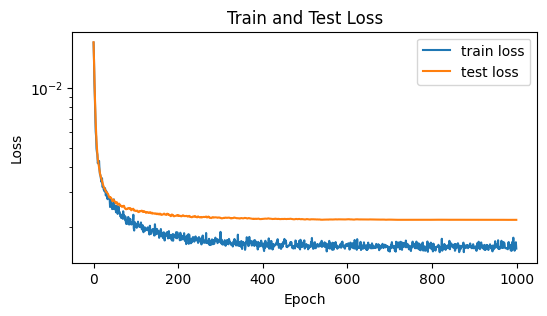

In [6]:
# Plot train and test loss
fig = plt.figure(figsize=(6, 3))
plt.plot(train_loss, label="train loss")
plt.plot(test_loss, label="test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Test Loss")
plt.yscale("log")
plt.legend()
plt.show()

In [7]:
# Model final loss
y_pred = model(X_test)
final_loss = loss_function(y_pred, y_test)
print(f"Final test loss: {final_loss:.7f}")

# Calculate loss of the mean-model
mean_model_pred = y_test.mean() * torch.ones_like(y_test)
mean_loss = loss_function(mean_model_pred, y_test)
print(f"Mean model loss: {mean_loss:.7f}")

Final test loss: 0.0021766
Mean model loss: 0.0020254


Train data


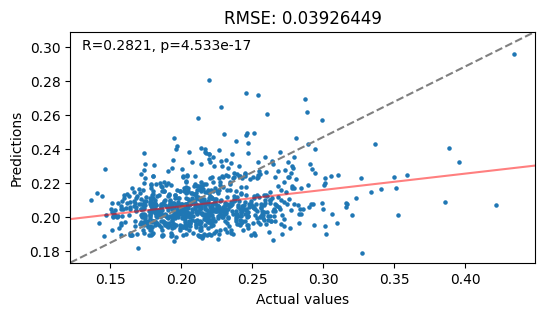

Test data


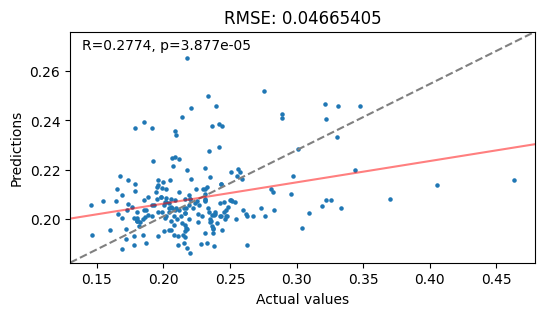

In [8]:
# Plot predictions against actual values

# Train data
y_train_pred = model(X_train)
print("Train data")
fig = plt.figure(figsize=(6, 3))
ax = plot.predicted_actual_scatter(
    y_train.cpu().detach().numpy().squeeze(),
    y_train_pred.cpu().detach().numpy().squeeze(),
)
plt.show()

# Test data
y_pred_test = model(X_test)
print("Test data")
fig = plt.figure(figsize=(6, 3))
ax = plot.predicted_actual_scatter(
    y_test.cpu().detach().numpy().squeeze(),
    y_pred_test.cpu().detach().numpy().squeeze(),
)
plt.show()